# Data Challenge : Introduction to Machine Learning (BGDIA703)

### Authors: 
#### Charlotte Laclau (charlotte.laclau@telecom-paris.fr)

This year's challenge is about text classification. 
For privacy reasons, you are only provided with the embedding learned on the original documents. 

### Fair document classification

The task is straightforward: assign the correct category to a text. This is thus a multi-class classification task with 28 classes to choose from.

The most adopted paradigm consists in training a network $f: \mathcal{X} \rightarrow \mathbb{R}^d$ which, from a given document $x \in \mathcal{X}$, extracts a feature vector $z \in \mathbb{R}^d$ which synthetizes the relevant caracteristics of $doc$. The diagnostic phase then consists, from an document $x$, to predict the label of the document based on the extracted features $z$. In this data challenge $d=768$. 

We directly provide you the embedding of each text (learned with BERT). 

The goal of this competition is to design a solution that is both accurate for predicting the label as well as fair with respect to some sensitive attribute (e.g. gender). Fairness in this context means that the model should not be biased toward a certain minority group present in the data. We explain this paradigm further in the evaluation part. 

### Downloading the Data: 

You can download the Dataset and evaluator script from the below links: 
**https://partage.imt.fr/index.php/s/3M3Mn3sN3TNSDEp**

**https://partage.imt.fr/index.php/s/CfajSjkAiq2oCLF**

After unzipping the file, you have one pickle file named ``data-challenge-student.pickle``.
In this file you have one dictionnary that contains the training set `X_train`, the test set `X_test`, the training label `Y_train`, and the information about the sensitive attribute in `S_train` and `S_test`.


## Introduction

Ce Data Challenge peut être divisé en trois étapes, qui seront présentées dans trois paragraphes distincts pour décrire le travail que j'ai effectué : 
1. [La première étape consiste à tester des modèles.](#section1)
2. [La deuxième étape à équilibrer les données et à changer de modèle.](#section2)
3. [La troisième étape à chercher les paramètres optimaux du modèle.](#section3)

En raison de la limitation de la longueur, je n'ai pas placé tous les tests dans ce notebook. J'ai uniquement présenté des modèles et du code représentatifs pour chaque étape afin de vous faire comprendre le travail que j'ai réalisé dans ce Data Challenge.

### Baseline

In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from evaluator import *

with open('data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)
    
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

In [1]:

X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)
clf = LogisticRegression(random_state=0, max_iter=5000).fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])

final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)

0.7375960362513924


<a id="section1"></a>
## I.Première tentative : changement de modèle


### 1.Baseline+standardscaler

In [3]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=5000,class_weight='balanced').fit(X_train_scaled, Y_train)
Y_pred = clf.predict(X_test_scaled)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(final_score)

0.7145025818023536


#### 1.1 Baseline + MinMaxScaler

In [4]:
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=5000).fit(X_train_scaled, Y_train)
Y_pred = clf.predict(X_test_scaled)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(final_score)

0.7326827914899361


<div class='alert alert-block alert-info'>Commentaire:

J'ai essayé de mettre à l'échelle les données, mais les résultats étaient inférieurs à ceux de la baseline. Cela montre que la mise à l'échelle des données ne permet pas d'amplifier les caractéristiques, mais au contraire, elle peut éliminer les caractéristiques nécessaires.
</div>

### 2.DecisionTreeClassifier

In [5]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,Y_train)

Y_pred = dt_clf.predict(X_test)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(final_score)

0.5597217358601747


### 3.RandomForestClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100) 

rf_clf.fit(X_train, Y_train)
Y_pred = rf_clf.predict(X_test)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(final_score)

0.5956814342866652


### 4.XGBoost

In [7]:
import xgboost as xgb
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    min_child_weight=1,
    use_label_encoder=False,
    eval_metric='mlogloss',  # 用于多分类
    objective='multi:softprob',  # 多分类的目标
    num_class=28,  # 类别总数
    verbosity=0
)


xgb_clf.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_test, Y_test)], verbose=False)

Y_pred = xgb_clf.predict(X_test)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(final_score)

/home/infres/xxu-23/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/infres/xxu-23/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.6574438916002425


### 5.SVM

In [8]:
from sklearn.svm import SVC
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)
svm = SVC()
svm.fit(X_train, Y_train)
Y_pred = svm.predict(X_test)
eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2

print(final_score)

0.7054093884407573


<div class='alert alert-block alert-info'>Commentaire:

Sur la base de l'essai mentionné précédemment, il se pourrait qu'il existe des paramètres pour le modèle SVM qui soient supérieurs à ceux de la baseline et qui nécessitent des explorations supplémentaires.
</div>

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC


X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=0.3, random_state=42)

svc_parameters = {
    'C': np.logspace(-4, 4, 10),  # Wider range of C
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Exploring more kernel types
    'gamma': np.logspace(-4, 4, 10),  # Wider range of gamma
    'class_weight': [None, 'balanced']  # Adding class_weight to handle imbalanced classes
}

clf = RandomizedSearchCV(SVC(random_state=0), svc_parameters, n_iter=10, cv=5, random_state=42, n_jobs=-1)


clf.fit(X_train, Y_train)


best_model = clf.best_estimator_
Y_pred = best_model.predict(X_test)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore'] + (1 - eval_scores['TPR_GAP'])) / 2

print(f"Best Parameters are {best_model}")
print(f"Final Score: {final_score}")
print(f"Total Runtime: {total_time} seconds")

Étant donné que les données sont volumineuses, la recherche de paramètres prend beaucoup de temps. Par conséquent, j'ai décidé de lancer ce code sur le cluster de l'école.

Best Parameters are SVC(C=21.54434690031882, gamma=0.005994842503189409, random_state=0)  
Final Score: 0.743105086064241  
Total Runtime: 8468.553272724152 seconds

<div class='alert alert-block alert-info'>Commentaire:

Les résultats finaux obtenus ne diffèrent pas beaucoup de ceux de la baseline, il est donc nécessaire de traiter les données ou d'essayer un autre modèle.
</div>

<a id="section2"></a>

## II. Deuxième tentative: traitement des données et remplacement du modèle

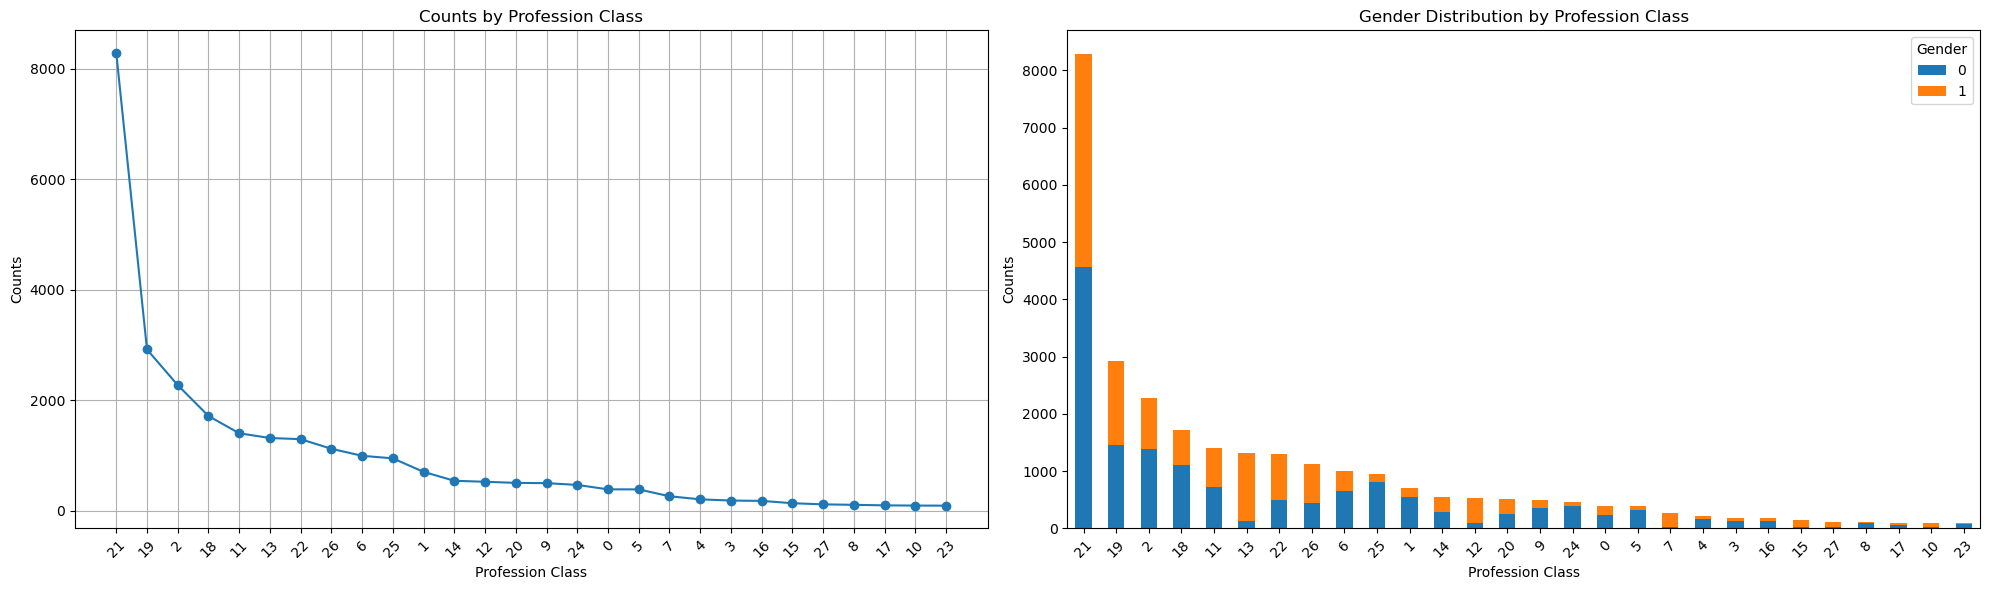

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def display_combined(data, gender_data):
    # compte du nombre de label
    counts = pd.DataFrame(data.value_counts())
    counts_df = counts.reset_index()
    counts_df.columns = ['profession_class', 'counts']

    # Creation de DataFrame
    df = pd.DataFrame({'profession_class': data, 'gender': gender_data})
    profession_order = df['profession_class'].value_counts().index
    gender_distribution = df.groupby('profession_class')['gender'].value_counts().unstack().fillna(0)
    gender_distribution = gender_distribution.reindex(profession_order)

    plt.figure(figsize=(20, 6))

    # Visualisation de Y
    plt.subplot(1, 2, 1)  
    plt.plot(counts_df.index, counts_df['counts'], marker='o')
    plt.xticks(counts_df.index, counts_df['profession_class'], rotation=45)
    plt.xlabel('Profession Class')
    plt.ylabel('Counts')
    plt.title('Counts by Profession Class')
    plt.grid(True)

    # Visualisation de genre
    plt.subplot(1, 2, 2)  
    gender_distribution.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.xticks(rotation=45)
    plt.xlabel('Profession Class')
    plt.ylabel('Counts')
    plt.title('Gender Distribution by Profession Class')
    plt.legend(title='Gender')

    plt.tight_layout()
    plt.show()

display_combined(Y, S)


<div class='alert alert-block alert-info'>Commentaire:  

Les données présentent une distribution en longue queue et le genre au sein de chaque catégorie est également déséquilibré, il est donc nécessaire d'équilibrer les données.
</div>

Après avoir essayé, équilibrer les données en fonction du genre donne de meilleurs résultats que d'équilibrer à la fois les catégories et le genre. Voici le code :

In [5]:
from sklearn.utils import resample
def resampling_gender(X_train,Y_train,S_train):
    data = pd.concat([X_train, Y_train, S_train], axis=1)

    data.columns = list(X_train.columns) + ['label', 'gender_class']

    balanced_data = pd.DataFrame()

    for label in data['label'].unique():
        subset = data[data['label'] == label]
        
        target_size = max(subset['gender_class'].value_counts().max(), subset['gender_class'].value_counts().min())
        
        for gender in subset['gender_class'].unique():
            gender_subset = subset[subset['gender_class'] == gender]
            
            gender_subset_upsampled = resample(gender_subset, 
                                            replace=True,     # avec remplacement
                                            n_samples=target_size, 
                                            random_state=123)
            balanced_data = pd.concat([balanced_data, gender_subset_upsampled])
            balanced_data = balanced_data.reset_index(drop=True)

    y_sortie = balanced_data['label']
    s_sortie = balanced_data['gender_class']
    x_new = balanced_data.iloc[:, :-2]

    return x_new,y_sortie,s_sortie

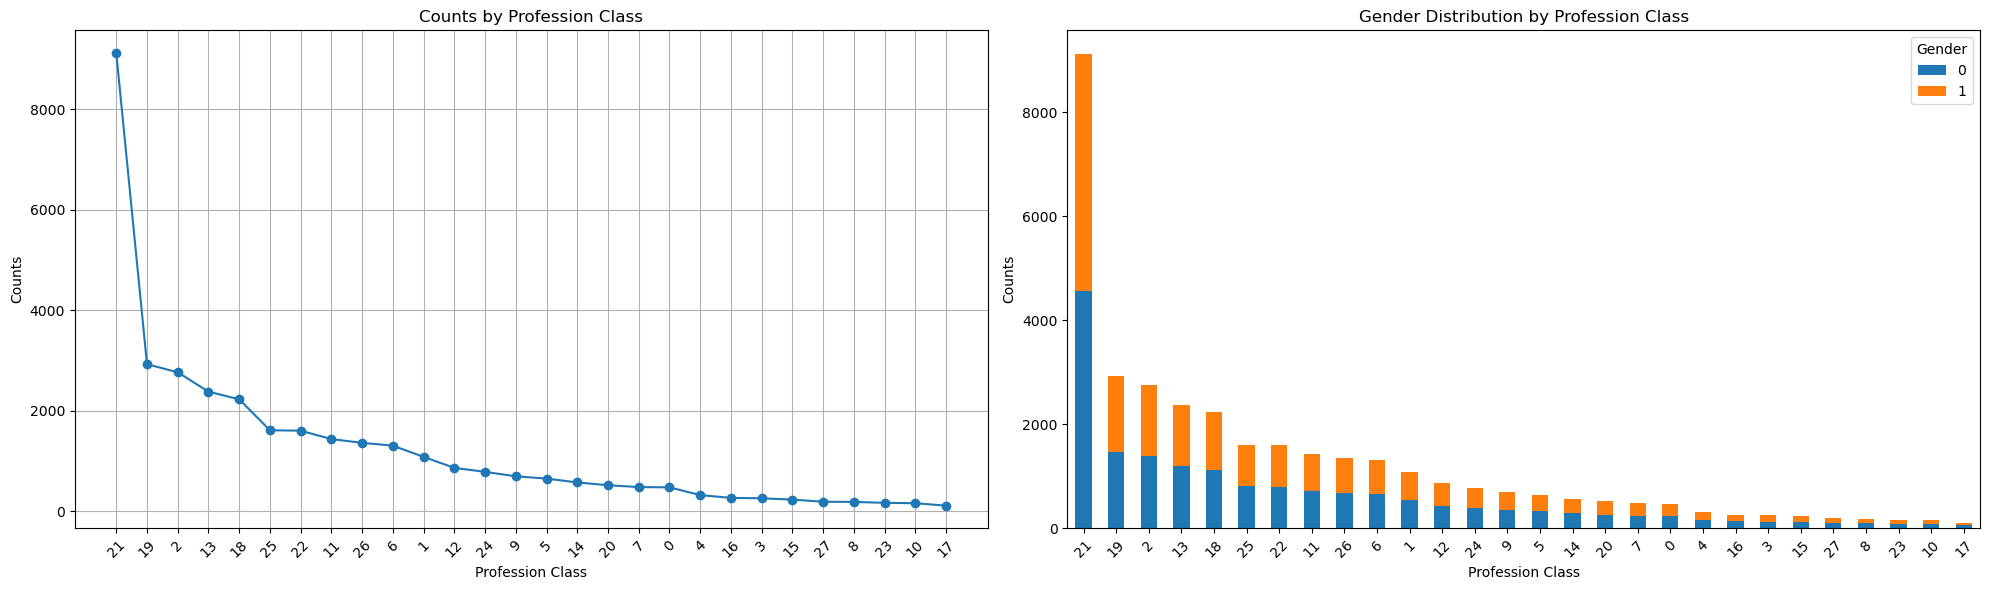

In [6]:
x_new,y_new ,s_new = resampling_gender(X,Y,S)
display_combined(y_new, s_new)

In [17]:
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(x_new, y_new, s_new, test_size=0.3, random_state=42)

svc = SVC(kernel='rbf', gamma=0.006, C=21.5, random_state=42)
svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)
eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)

0.864209099506087


<div class='alert alert-block alert-info'>Commentaire:

Après avoir équilibré les données, les résultats ont été optimisés sous le même modèle, mais les scores soumis sur le site web sont inférieurs à ceux obtenus lors de l'entraînement sur l'ordinateur, ce qui est une manifestation de surajustement. En raison du temps, ce problème n'a pas été résolu dans ce défi, mais plutôt en testant constamment des modèles et en cherchant des hyperparamètres plus appropriés. De plus, l'entraînement sur l'ensemble des données équilibrées donne de meilleurs résultats.
</div>

### 2.1 Utiliser réseau de neurones entièrement connecté (FNN) comme modèle.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import StratifiedKFold

2024-03-19 16:26:20.621155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 16:26:29.524169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2024-03-19 16:26:29.525172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2024-03-19 16:26:29.525196: W tensorflow/compiler/tf2tensorrt/util

Comme les données fournies sont des vecteurs de caractéristiques traités par BERT, elles devraient pouvoir être entraînées via un réseau de neurones.  

Voici la première fonction que j'ai construite, elle comporte trois couches, les trois premières utilisent la même fonction d'activation (Sigmoid), les deux premières couches utilisent les mêmes fonctions (BatchNormalization, Dropout) pour prévenir le surajustement. La dernière couche est la couche de sortie, avec 28 nœuds, représentant les catégories de Y.

In [19]:
## build model#1
## 1) 5 split,30 epoch, num_model_b :1(0th), score:0.766,num_csv:10
def build_model_1():
    model = Sequential()
    model.add(Dense(512,input_shape=(768,),activation = 'sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # model.add(AttentionLayer())
    model.add(Dense(256, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(28, activation='sigmoid'))
        
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

K.clear_session()

In [21]:
checkpoint_filepath = '/home/infres/xxu-23/data/model_store'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
x_new,y_new,s_new = resampling_gender(X,Y,S)

In [24]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
X_1 = x_new.values
Y_1 = y_new.values
best_val_accuracy = 0.0  
best_model_weights_path = None  
# Y_1 = to_categorical(Y_1, num_classes=28)
for i, (train_index, test_index) in enumerate(skf.split(X_1, Y_1)):
    print('---------------------------------------')
    print(f'the {i+1}th train')
    print('---------------------------------------')
    model = build_model_1()
    
    X_train, Y_train = X_1[train_index], Y_1[train_index]
    X_test, Y_test = X_1[test_index], Y_1[test_index]
    Y_train_categorical = to_categorical(Y_train, num_classes=28)
    Y_test_categorical = to_categorical(Y_test, num_classes=28)

    early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min',min_delta=1e-4)
    history = model.fit(X_train, Y_train_categorical, epochs=30, batch_size=32, 
                        validation_data=(X_test, Y_test_categorical), callbacks=[early_stopping],verbose = 0)


    val_accuracy = max(history.history['val_accuracy'])
    print('val_accuracy:',val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights_path = f'/home/infres/xxu-23/data/model_store/checkpoint_fold_{i+1}.h5'
        model.save_weights(best_model_weights_path)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print(f'Best Model Weights Saved to: {best_model_weights_path}')


---------------------------------------
the 1th train
---------------------------------------
val_accuracy: 0.8949719071388245
---------------------------------------
the 2th train
---------------------------------------
val_accuracy: 0.8916582465171814
---------------------------------------
the 3th train
---------------------------------------
val_accuracy: 0.894107460975647
---------------------------------------
the 4th train
---------------------------------------
val_accuracy: 0.894107460975647
---------------------------------------
the 5th train
---------------------------------------
val_accuracy: 0.889769434928894
Best Validation Accuracy: 0.8949719071388245
Best Model Weights Saved to: /home/infres/xxu-23/data/model_store/checkpoint_fold_1.h5


<div class='alert alert-block alert-info'>Commentaire:  

Le code mentionné utilise StratifiedKFold pour l'entraînement du modèle, avec un total de 5 entraînements, chacun comprenant 30 epochs. Finalement, le résultat obtenu sur le site est de 0.766. Cela montre que le modèle de réseau de neurones dispose d'un grand espace d'exploration.
</div>

Ensuite, j'ai ajusté les paramètres de la fonction et obtenu des résultats différents. Voici les ajustements de la fonction :

In [ ]:
def build_model_2():
    model = Sequential()
    model.add(Dense(512,input_shape=(768,),activation = 'elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(256, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # model.add(AttentionLayer())
    model.add(Dense(256, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(28, activation='softmax'))
        
    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Les paramètres configurés suivants:

| Numero | Nb_split | Nb_epochs | Optimiser | Nb_droupout | Score |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| 1 | 5 | 30 | 'SGD' | 0.5 | 0.7708 |
| 2 | 8 | 40 | 'SGD' | 0.5 | 0.774 |
| 3 | 5 | 50 | 'SGD' | 0.5 | 0.765 |
| 4 | 5 | 30 | 'RMSprop' | 0.5 | - |
| 5 | 5 | 30 | 'Adamax' | 0.5 | 0.756 |
| 6 | 5 | 30 | 'Nadam' | 0.5 | 0.756 |
| 7 | 5 | 30 | 'SGD' | 0.2 | 0.754 |
| 8 | 5 | 30 | 'SGD' | 0.4 | 0.777 |
| 9 | 5 | 30 | 'SGD' | 0.45 | 0.773 |
| 10 | 5 | 30 | 'SGD' | 0.4 , 0.5 | 0.776 |
| 11 | 5 | 40 | 'SGD' | 0.4 , 0.45 | 0.768 |
| 12 | 5 | 40 | 'SGD' | 0.4 | 0.673 |




<div class='alert alert-block alert-info'>Commentaire:

En résumé, le modèle obtient les meilleurs résultats avec les paramètres 'SGD' et 'Dropout = 0.4'.

Il est possible que il ait atteint la limite maximale des capacités du modèle. De plus, chaque session d'entraînement nécessite plus de 10 minutes, donc il faut envisager d'essayer un nouveau modèle ou d'autres ajustements.
</div>

<a id="section3"></a>

## III. Troisième tentative : la modélisation de la régression

Pour cette partie, j'ai discuté avec Youssef et Yassine. Nous avons trouvé que la fonction de régression atteignait un score de **0.78** avec les paramètres suivants : (solver='newton-cg', C=0.1, tol=1e-5, max_iter=7000), et il était nécessaire d'inclure le genre S comme une caractéristique dans l'entraînement. Ainsi, nous avons exploré les paramètres.

In [5]:
x_new,y_new ,s_new = resampling_gender(X,Y,S)
X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(x_new,y_new,s_new, test_size=0.3, random_state=42)
X_train_new = pd.concat([X_train,S_train],axis=1)
X_train_new.columns = X_train_new.columns.astype(str)
model_cf = LogisticRegression(random_state=42, solver='newton-cg', C=0.1, tol=1e-5, max_iter=7000)

model_cf.fit(X_train_new, Y_train)
X_test_new = pd.concat([X_test,S_test],axis=1)
X_test_new.columns = X_test_new.columns.astype(str)

Y_pred = model_cf.predict(X_test_new)

eval_scores, confusion_matrices_eval = gap_eval_scores(Y_pred, Y_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)


0.80674822683069


Après avoir effectué des tests, il s'est avéré que les résultats obtenus en entraînant le modèle sur l'ensemble des données étaient meilleurs que ceux obtenus en divisant les données en ensembles d'entraînement et de test. Voici les différents résultats de mes tests:

Les paramètres configurés suivants:

| Numero | C | Score |
|:-----:|:-----:|:-----:|
| 1 | 0.09 | 0.784 |
| 2 | 0.085 | 0.781 | 
| 3 | 0.08 | 0.778 |
| 4 | 0.05 | 0.781 |
| 5 | 0.06 | 0.782 |
| 6 | 0.058 | 0.782 |
| 7 | 0.03 | 0.783 |
| 8 | 0.035 | 0.783 |
| 9 | 0.02 | 0.780 |
| 10 | 0.025 | 0.779 |
| 11 | 0.063 | 0.784 |
| 12 | 0.062 | 0.7879 |
| 13 | 0.0615 | 0.7879 |


<div class='alert alert-block alert-info'>Commentaire:

D'après les tests mentionnés ci-dessus, on peut voir que le modèle présente une solution optimale locale près des valeurs de C à 0.3, 0.6, 0.9, mais atteint l'optimum à la valeur de 0.62.
</div>

#### 3.1 Classification étape par étape

Comme les données présentent une distribution en 'Long tail', il existe un risque de surajustement pour les catégories les plus nombreuses. L'approche de ce modèle est de d'abord séparer les catégories les plus nombreuses des autres catégories moins nombreuses, puis de classer ces dernières. Le score final peut atteindre 0.77.

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
x_new,y_new ,s_new = resampling_gender(X,Y,S)


max_label = y_new.value_counts().idxmax()

y_big_classes = np.where(y_new == max_label,'bigclass', 'smallclass')
print(y_big_classes)

X_train, X_test, y_big_train, y_big_test, y_new_train, y_new_test,S_train,S_test = train_test_split(
    x_new, y_big_classes, y_new,s_new, test_size=0.2, random_state=42
)

X_train_new = pd.concat([X_train,S_train],axis=1)
X_train_new.columns = X_train_new.columns.astype(str)



clf_big = RandomForestClassifier(random_state=42,n_estimators=200)
clf_big.fit(X_train_new, y_big_train)

['smallclass' 'smallclass' 'smallclass' ... 'smallclass' 'smallclass'
 'smallclass']


RandomForestClassifier(n_estimators=200, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression

is_other_classes = y_big_train == 'smallclass'
X_train_other = X_train_new[is_other_classes]
Y_train_other = y_new_train[is_other_classes]
# S_train_other = S_train[is_other_classes]
# X_train_new = pd.concat([X_train_other,S_train_other],axis=1)
# X_train_new.columns = X_train_new.columns.astype(str)



clf_other = LogisticRegression(random_state=42,solver='newton-cg', C=0.3, tol=1e-4,  max_iter=50000)
clf_other.fit(X_train_other, Y_train_other)



LogisticRegression(C=0.3, max_iter=50000, random_state=42, solver='newton-cg')

In [11]:
X_test_new = pd.concat([X_test,S_test],axis=1)
X_test_new.columns = X_test_new.columns.astype(str)
y_big_pred = clf_big.predict(X_test_new)
final_predictions = np.empty_like(y_big_pred, dtype=object)
final_predictions[y_big_pred == 'bigclass'] = max_label
smallclass_indices = (y_big_pred == 'smallclass')
X_test_smallclass = X_test_new[smallclass_indices]
# S_test_smallclass = S_test[smallclass_indices]

# X_test_new = pd.concat([X_test_smallclass,S_test_smallclass],axis=1)
# X_test_new.columns = X_test_new.columns.astype(str)

if X_test_smallclass.size > 0: 
    y_small_pred = clf_other.predict(X_test_smallclass)
    final_predictions[smallclass_indices] = y_small_pred
    
final_predictions = final_predictions.astype(int)

eval_scores, confusion_matrices_eval = gap_eval_scores(final_predictions, y_new_test, S_test, metrics=['TPR'])
final_score = (eval_scores['macro_fscore']+ (1-eval_scores['TPR_GAP']))/2
print(final_score)

0.8531966248166197


<div class='alert alert-block alert-info'>Commentaire:

En raison du manque de temps, je n'ai pas pu approfondir mes recherches sur ce modèle, qui a atteint un score de 0.77. Si j'avais eu plus de temps, j'aurais pu explorer davantage ce modèle.

</div>

## IV. Conclusion

Suite à ce data challenge, le modèle final obtenu est LogisticRegression avec les paramètres (solver='newton-cg', C=0.062, tol=1e-5, max_iter=7000), qui a donné les meilleurs résultats, pouvant atteindre 0.7879. Cependant, il reste encore des problèmes à améliorer : 
- 1. Les données d'entraînement utilisées sont l'ensemble des données, ce qui entraîne un surajustement, c'est-à-dire que les résultats sur l'ensemble de test sont meilleurs que les résultats finaux, nécessitant un traitement supplémentaire des données.
- 2. Les paramètres du modèle pourraient ne pas être optimaux, nécessitant la recherche d'une méthode plus économique pour trouver les meilleurs paramètres. Peut-être que l'optimisation bayésienne pourrait résoudre ce problème, mais par manque de temps, je n'ai pas pu approfondir cette voie.